In [162]:
# import modules
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, minmax_scale
from sklearn.metrics import confusion_matrix, log_loss, f1_score

import random
from math import floor
from scipy.stats import mode, scoreatpercentile

print("Seaborn version : ", sns.__version__)
sns.set()
#sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_theme(style="ticks", palette="pastel")



# upload data
train = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/train.csv',
                   index_col=0)
test = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/test.csv',
                  index_col=0)
submit = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/sample_submission.csv')

Seaborn version :  0.11.1


In [163]:
df = train.copy()

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  FLAG_MOBIL     26457 non-null  int64  
 12  work_phone     26457 non-null  int64  
 13  phone          26457 non-null  int64  
 14  email          26457 non-null  int64  
 15  occyp_type     18286 non-null  object 
 16  family_size    26457 non-null  float64
 17  begin_month    26457 non-null  float64
 18  credit

In [165]:
# defs
def show_4digits(x) : 
    return str(x)[:3]



In [166]:
# outliers
df.drop((df[df['child_num']>=6]).index, inplace = True)

# no information
df.drop('FLAG_MOBIL',axis = 1, inplace = True)

# negative to positive
df['DAYS_BIRTH'] = -df['DAYS_BIRTH']
df['DAYS_EMPLOYED'] = -df['DAYS_EMPLOYED']
df['begin_month'] = -df['begin_month']

# handling the missing values
## occyp_type == NaN
df['occyp_type'] = df.occyp_type.fillna('missing')
df.loc[(df.DAYS_EMPLOYED == -365243)&(df.occyp_type.isna()), 'occyp_type'] = 'in_occyp'
## DAYS_EMPLOYED == 365243
df['DAYS_EMPLOYED'][df['DAYS_EMPLOYED'] == -365243] = 0

In [167]:
# personal_id
df['personal_id']= \
df['gender']+\
df['car']+\
df['income_total'].apply(lambda x: str(int(x)).zfill(7))+\
df['edu_type'].apply(show_4digits)+\
df['family_type'].apply(show_4digits)+\
df['house_type'].apply(show_4digits)+\
df['DAYS_BIRTH'].apply(lambda x: str(x).zfill(5))+\
df['DAYS_EMPLOYED'].apply(lambda x: str(x).zfill(5))+\
df['occyp_type'].apply(show_4digits)

# 재산, 연락처에 관한 정보들을 묶어서 분류
df['group_property'] = df['car'].astype(str)   + df['reality'].astype(str)
df['group_contacts'] = df['phone'].astype(str) + df['work_phone'].astype(str) + df['email'].astype(str)

In [168]:
# 현재 하고 있는 일을 시작하게 된 나이(날짜) = 일을 하지 않았던 기간 
df['DAYS_nowork'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']

# 가족 수와 관련된 변수
df['adult_num'] = df['family_size'] - df['child_num']
df.loc[df.child_num >= 5, 'child_num'] = 5
df.loc[df.child_num >= 5, 'family_size'] = df.loc[df.child_num >= 5, 'child_num'] + df.loc[df.child_num >= 5, 'adult_num']

# 소득과 관련된 변수와 조합
df['income_per_child'] = df['income_total']/ df['child_num']  #소득을 아이 수로 나눠 각 아이에게 할당 될 수 있는 금액을 계산 
df['income_per_family']= df['income_total']/ df['family_size']#소득을 가족 수로 나눠 각 인원에게 할당 될 수 있는 금액을 계산
df['income_per_age']   = df['income_total']/ df['DAYS_BIRTH'] #소득을 나이로 나눠 나이 대비 얼마나 버는지에 대한 지표 생성

# 로그 변환(income_total)
df['income_total_log'] = np.log(df['income_total']+1)

# 날짜표기 변환(begin_month) : 4로 나누어 계절로 분할
df['begin_season'] = df['begin_month'].apply(lambda x: floor(x/4))

# 날짜표기 변환(DAYS_EMPLOYED) : 개월로 binning
df['mm_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/30.4375))

# 날쨔 표기 변환(DAYS_EMPLOYED): 연차로 binning
df['yy_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/365.25))



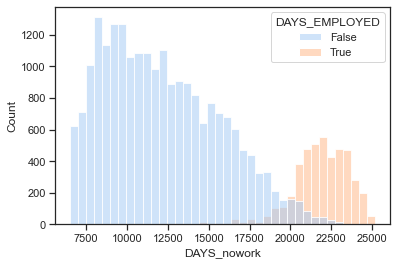

In [169]:
sns.histplot(x = df.DAYS_nowork, hue = df.DAYS_EMPLOYED == 0)

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26451 entries, 0 to 26456
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             26451 non-null  object 
 1   car                26451 non-null  object 
 2   reality            26451 non-null  object 
 3   child_num          26451 non-null  int64  
 4   income_total       26451 non-null  float64
 5   income_type        26451 non-null  object 
 6   edu_type           26451 non-null  object 
 7   family_type        26451 non-null  object 
 8   house_type         26451 non-null  object 
 9   DAYS_BIRTH         26451 non-null  int64  
 10  DAYS_EMPLOYED      26451 non-null  int64  
 11  work_phone         26451 non-null  int64  
 12  phone              26451 non-null  int64  
 13  email              26451 non-null  int64  
 14  occyp_type         26451 non-null  object 
 15  family_size        26451 non-null  float64
 16  begin_month        264

In [171]:
# outliers
train.drop((train[train['child_num']>=6]).index, inplace = True)

In [172]:
for df in [train, test] : 
    # no information
    df.drop('FLAG_MOBIL',axis = 1, inplace = True)

    # negative to positive
    df['DAYS_BIRTH'] = -df['DAYS_BIRTH']
    df['DAYS_EMPLOYED'] = -df['DAYS_EMPLOYED']
    df['begin_month'] = -df['begin_month']

    # handling the missing values
    ## occyp_type == NaN
    df['occyp_type'] = df.occyp_type.fillna('missing')
    df.loc[(df.DAYS_EMPLOYED == -365243)&(df.occyp_type.isna()), 'occyp_type'] = 'in_occyp'
    ## DAYS_EMPLOYED == 365243
    df['DAYS_EMPLOYED'][df['DAYS_EMPLOYED'] == -365243] = 0

In [173]:
for df in [train, test] : 
    # personal_id
    df['personal_id']= \
    df['gender']+\
    df['car']+\
    df['income_total'].apply(lambda x: str(int(x)).zfill(7))+\
    df['edu_type'].apply(show_4digits)+\
    df['family_type'].apply(show_4digits)+\
    df['house_type'].apply(show_4digits)+\
    df['DAYS_BIRTH'].apply(lambda x: str(x).zfill(5))+\
    df['DAYS_EMPLOYED'].apply(lambda x: str(x).zfill(5))+\
    df['occyp_type'].apply(show_4digits)

    # 재산, 연락처에 관한 정보들을 묶어서 분류
    df['group_property'] = df['car'].astype(str)   + df['reality'].astype(str)
    df['group_contacts'] = df['phone'].astype(str) + df['work_phone'].astype(str) + df['email'].astype(str)

In [174]:
for df in [train, test] : 
    # 현재 하고 있는 일을 시작하게 된 나이(날짜) = 일을 하지 않았던 기간 
    df['DAYS_nowork'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']

    # 가족 수와 관련된 변수
    df['adult_num'] = df['family_size'] - df['child_num']
    df.loc[df.child_num >= 5, 'child_num'] = 5
    df.loc[df.child_num >= 5, 'family_size'] = df.loc[df.child_num >= 5, 'child_num'] + df.loc[df.child_num >= 5, 'adult_num']

    # 소득과 관련된 변수와 조합
    df['income_per_child'] = df['income_total']/ df['child_num']  #소득을 아이 수로 나눠 각 아이에게 할당 될 수 있는 금액을 계산 
    df['income_per_family']= df['income_total']/ df['family_size']#소득을 가족 수로 나눠 각 인원에게 할당 될 수 있는 금액을 계산
    df['income_per_age']   = df['income_total']/ df['DAYS_BIRTH'] #소득을 나이로 나눠 나이 대비 얼마나 버는지에 대한 지표 생성

    # 로그 변환(income_total)
    df['income_total_log'] = np.log(df['income_total']+1)

    # 날짜표기 변환(begin_month) : 4로 나누어 계절로 분할
    df['begin_season'] = df['begin_month'].apply(lambda x: floor(x/4))

    # 날짜표기 변환(DAYS_EMPLOYED) : 개월로 binning
    df['mm_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/30.4375))

    # 날쨔 표기 변환(DAYS_EMPLOYED): 연차로 binning
    df['yy_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: floor(x/365.25))



In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26451 entries, 0 to 26456
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             26451 non-null  object 
 1   car                26451 non-null  object 
 2   reality            26451 non-null  object 
 3   child_num          26451 non-null  int64  
 4   income_total       26451 non-null  float64
 5   income_type        26451 non-null  object 
 6   edu_type           26451 non-null  object 
 7   family_type        26451 non-null  object 
 8   house_type         26451 non-null  object 
 9   DAYS_BIRTH         26451 non-null  int64  
 10  DAYS_EMPLOYED      26451 non-null  int64  
 11  work_phone         26451 non-null  int64  
 12  phone              26451 non-null  int64  
 13  email              26451 non-null  int64  
 14  occyp_type         26451 non-null  object 
 15  family_size        26451 non-null  float64
 16  begin_month        264

In [176]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
#numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  19
Number of Categorical features:  11


In [177]:
target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [178]:
seed = 42
n_fold = 5
n_class = 3

In [179]:
X

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,group_contacts,DAYS_nowork,adult_num,income_per_child,income_per_family,income_per_age,income_total_log,begin_season,mm_EMPLOYED,yy_EMPLOYED
index,,,,,,,,,,,,,,,,,,,,,
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,13899,...,000,9190,2.0,inf,101250.0,14.569393,12.218500,1,154,12
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,11380,...,001,9840,2.0,247500.0,82500.0,21.748682,12.419170,1,50,4
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,19087,...,100,14653,2.0,inf,225000.0,23.576256,13.017005,5,145,12
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,15088,...,100,12996,2.0,inf,101250.0,13.421262,12.218500,9,68,5
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,15037,...,000,12932,2.0,inf,78750.0,10.474164,11.967187,6,69,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,12079,...,000,10095,2.0,112500.0,56250.0,18.627370,12.323860,0,65,5
26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,15291,...,000,12816,1.0,180000.0,90000.0,11.771630,12.100718,11,81,6
26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,10082,...,000,8067,2.0,inf,146250.0,29.012101,12.586223,6,66,5


In [180]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats#+ ['gender', 'car', 'reality', 'phone', 'email', 'work_phone']
print('category features : {}'.format(cat_cols))

# 15Fold-CV (StratifiedKFold)
for fold in range(len(folds)):
    print(f'\n----------------- Fold {fold} -----------------\n')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
    train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

    model_cat = CatBoostClassifier(n_estimators=3000, max_depth=8, random_seed=1042, learning_rate=0.04, bootstrap_type ='Bernoulli')
    model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=50, verbose=100)

    cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
    cat_pred_test += model_cat.predict_proba(X_test) / n_fold
    print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')

category features : ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'personal_id', 'group_property', 'group_contacts']

----------------- Fold 0 -----------------



KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([8462, 9021, 10731, 25313, 25390], dtype='int64', name='index'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [183]:
X.iloc[[8462, 9021, 10731, 25313, 25390]]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,group_contacts,DAYS_nowork,adult_num,income_per_child,income_per_family,income_per_age,income_total_log,begin_season,mm_EMPLOYED,yy_EMPLOYED
index,,,,,,,,,,,,,,,,,,,,,
8463,M,Y,Y,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,16204,...,110,15279,2.0,112500.0,37500.0,6.942730,11.630717,14,30,2
9023,F,Y,N,1,112500.0,Commercial associate,Secondary / secondary special,Married,Office apartment,14499,...,000,11639,2.0,112500.0,37500.0,7.759156,11.630717,3,93,7
10734,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Separated,House / apartment,18865,...,000,18865,1.0,inf,157500.0,8.348794,11.967187,11,0,0
25317,M,Y,N,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,17349,...,000,16813,2.0,inf,90000.0,10.375238,12.100718,3,17,1
25395,F,N,Y,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,10572,...,000,10435,2.0,inf,90000.0,17.026107,12.100718,0,4,0


In [182]:
X.iloc[8462]

gender                                             M
car                                                Y
reality                                            Y
child_num                                          1
income_total                                112500.0
income_type                                  Working
edu_type               Secondary / secondary special
family_type                                  Married
house_type                         House / apartment
DAYS_BIRTH                                     16204
DAYS_EMPLOYED                                    925
work_phone                                         1
phone                                              1
email                                              0
occyp_type                                   Drivers
family_size                                      3.0
begin_month                                     57.0
personal_id          MY0112500SecMarHou1620400925Dri
group_property                                